In [1]:
!pip -q install -U transformers accelerate datasets indic-transliteration scikit-learn
import torch, sys
print("Torch:", torch.__version__, "| CUDA:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 59.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.6/159.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 68.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 34.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 76.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.0 MB/s

# Imports, Config

In [2]:
import os, json, math, random, glob
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoTokenizer, AutoModel, AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW  # ✅ moved here

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

INPUT_ROOT = Path("/kaggle/input")
WORK_DIR   = Path("/kaggle/working")
WORK_DIR.mkdir(parents=True, exist_ok=True)

TEACHER_MODEL_ID = "csebuetnlp/banglabert"           # teacher
STUDENT_MODEL_ID = "distilroberta-base"         # student

# Data / training
MAX_LENGTH_TEACHER = 128
MAX_LENGTH_STUDENT = 128
BATCH_SIZE = 16
EPOCHS_TEACHER = 3
EPOCHS_STUDENT = 4
LR_TEACHER = 2e-5
LR_STUDENT = 3e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1

# Classic KD
KD_T = 3.0
KD_ALPHA = 0.5       # weight for KL vs CE

# MiniLM-style intermediate weights
GAMMA_HIDDEN = 1.0   # hidden state MSE
GAMMA_ATT    = 1.0   # attention MSE
GAMMA_REL    = 1.0   # value-relation (token-token similarity) MSE

# Early stop
PATIENCE = 2


In [22]:
# 🔍 Inspect Kaggle input directories
import os
for root, dirs, files in os.walk("/kaggle/input"):
    print(root)
    for f in files:
        print("   ", f)


/kaggle/input
    all_negative_3307.txt
    all_positive_8500.txt


# Load pos.txt / neg.txt from /kaggle/input and split

In [3]:
# ✅ Update this to the exact folder printed above
DATA_DIR = Path("/kaggle/input")

pos_path = DATA_DIR / "all_positive_8500.txt"
neg_path = DATA_DIR / "all_negative_3307.txt"

# Verify
print("pos exists:", pos_path.exists())
print("neg exists:", neg_path.exists())

# Load lines
def read_lines(p: Path):
    with open(p, "r", encoding="utf-8") as f:
        return [ln.strip() for ln in f if ln.strip()]

pos_lines = read_lines(pos_path)
neg_lines = read_lines(neg_path)

print(f"✅ Loaded {len(pos_lines)} positive and {len(neg_lines)} negative samples")


pos exists: True
neg exists: True
✅ Loaded 8500 positive and 3307 negative samples


In [4]:
# Define dataset directory
DATA_DIR = Path("/kaggle/input")

# Define exact file paths
pos_path = DATA_DIR / "all_positive_8500.txt"
neg_path = DATA_DIR / "all_negative_3307.txt"

# Check existence
if not pos_path.exists() or not neg_path.exists():
    raise FileNotFoundError(f"❌ Files not found. Got pos={pos_path.exists()}, neg={neg_path.exists()}")

# Read lines safely
def read_lines(p: Path):
    with open(p, "r", encoding="utf-8") as f:
        return [ln.strip() for ln in f if ln.strip()]

# Load
pos_lines = read_lines(pos_path)
neg_lines = read_lines(neg_path)
print(f"✅ Loaded {len(pos_lines)} positive and {len(neg_lines)} negative samples")

# Build DataFrame
import pandas as pd
df_pos = pd.DataFrame({"text": pos_lines, "label": 1})
df_neg = pd.DataFrame({"text": neg_lines, "label": 0})
df = pd.concat([df_pos, df_neg], ignore_index=True).sample(frac=1.0, random_state=42).reset_index(drop=True)
print(df.head())
print(df["label"].value_counts())

# Split train/val/test
from sklearn.model_selection import train_test_split
train_df, tmp_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
val_df, test_df  = train_test_split(tmp_df, test_size=0.5, stratify=tmp_df["label"], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


✅ Loaded 8500 positive and 3307 negative samples
                                                text  label
0  আমার বাংলাদেশের নাটকের ভুতে ধরেছে, ওঝা কোথায় প...      1
1  ভাই, আপনার হার্ড ফ্যান আমি!বাট এইযে এই নাটকে য...      0
2  অনেক ভালো একটা নাটক ।।অনেক ভালোবাসি ভাই তুমাকে...      1
3                           বালের নাটক বালের কনসেপ্ট      0
4             দারুন হয়েছে, এই রকম নাটক আরো দেখতে চাই      1
label
1    8500
0    3307
Name: count, dtype: int64
Train: 9445, Val: 1181, Test: 1181


# Transliteration helper

In [6]:
from indic_transliteration import sanscript
from indic_transliteration.sanscript import transliterate

def transliterate_bn_text(text: str) -> str:
    try:
        return transliterate(text, sanscript.BENGALI, sanscript.ITRANS)
    except Exception:
        return text


# Datasets & Tokenizers (Teacher, Student, Paired)

In [7]:
class SimpleDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128, use_translit=False):
        self.texts = df.text.tolist()
        self.labels = df.label.tolist()
        self.tk = tokenizer; self.max_len = max_len; self.use_tr = use_translit
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        txt = self.texts[i]
        if self.use_tr: txt = transliterate_bn_text(txt)
        enc = self.tk(txt, truncation=True, max_length=self.max_len, return_tensors="pt")
        item = {k:v.squeeze(0) for k,v in enc.items()}
        item["labels"] = torch.tensor(self.labels[i], dtype=torch.long)
        return item

def pad_collate(batch, pad_id):
    ids = [b["input_ids"] for b in batch]
    masks = [b["attention_mask"] for b in batch]
    labels = torch.stack([b["labels"] for b in batch])
    tti = [b.get("token_type_ids") for b in batch]
    max_len = max(x.size(0) for x in ids)
    pad = lambda x, val: torch.cat([x, torch.full((max_len-x.size(0),), val, dtype=torch.long)])
    ids = torch.stack([pad(x, pad_id) for x in ids])
    masks = torch.stack([pad(x, 0) for x in masks])
    out = {"input_ids": ids, "attention_mask": masks, "labels": labels}
    if tti[0] is not None:
        tti = torch.stack([pad(x, 0) for x in tti])
        out["token_type_ids"] = tti
    return out

# paired dataset to feed student inputs (transliterated) and teacher inputs (original)
class PairedDataset(Dataset):
    def __init__(self, df, student_tok, teacher_tok, max_len_s=128, max_len_t=128):
        self.txts = df.text.tolist()
        self.lbls = df.label.tolist()
        self.s_tk, self.t_tk = student_tok, teacher_tok
        self.mls, self.mlt = max_len_s, max_len_t
    def __len__(self): return len(self.lbls)
    def __getitem__(self, i):
        bn = self.txts[i]
        tr = transliterate_bn_text(bn)
        s = self.s_tk(tr, truncation=True, max_length=self.mls, return_tensors="pt")
        t = self.t_tk(bn, truncation=True, max_length=self.mlt, return_tensors="pt")
        item = {
            "s_input_ids": s["input_ids"].squeeze(0),
            "s_attention_mask": s["attention_mask"].squeeze(0),
            "t_input_ids": t["input_ids"].squeeze(0),
            "t_attention_mask": t["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.lbls[i], dtype=torch.long),
        }
        if "token_type_ids" in s: item["s_token_type_ids"] = s["token_type_ids"].squeeze(0)
        if "token_type_ids" in t: item["t_token_type_ids"] = t["token_type_ids"].squeeze(0)
        return item

def paired_collate(batch, s_pad, t_pad):
    def pad_stack(tensors, pad_val):
        L = max(x.size(0) for x in tensors)
        return torch.stack([torch.cat([x, torch.full((L-x.size(0),), pad_val, dtype=torch.long)]) for x in tensors])

    s_ids = pad_stack([b["s_input_ids"] for b in batch], s_pad)
    s_msk = pad_stack([b["s_attention_mask"] for b in batch], 0)
    t_ids = pad_stack([b["t_input_ids"] for b in batch], t_pad)
    t_msk = pad_stack([b["t_attention_mask"] for b in batch], 0)
    labels = torch.stack([b["labels"] for b in batch])

    out = {
        "s_input_ids": s_ids, "s_attention_mask": s_msk,
        "t_input_ids": t_ids, "t_attention_mask": t_msk,
        "labels": labels
    }
    if "s_token_type_ids" in batch[0]:
        out["s_token_type_ids"] = pad_stack([b["s_token_type_ids"] for b in batch], 0)
    if "t_token_type_ids" in batch[0]:
        out["t_token_type_ids"] = pad_stack([b["t_token_type_ids"] for b in batch], 0)
    return out

teacher_tok = AutoTokenizer.from_pretrained(TEACHER_MODEL_ID)
student_tok = AutoTokenizer.from_pretrained(STUDENT_MODEL_ID)

# teacher loaders (for teacher fine-tune + eval)
train_teacher_ds = SimpleDataset(train_df, teacher_tok, MAX_LENGTH_TEACHER, use_translit=False)
val_teacher_ds   = SimpleDataset(val_df,   teacher_tok, MAX_LENGTH_TEACHER, use_translit=False)
test_teacher_ds  = SimpleDataset(test_df,  teacher_tok, MAX_LENGTH_TEACHER, use_translit=False)

train_teacher_loader = DataLoader(train_teacher_ds, batch_size=BATCH_SIZE, shuffle=True,
                                  collate_fn=lambda b: pad_collate(b, teacher_tok.pad_token_id))
val_teacher_loader   = DataLoader(val_teacher_ds,   batch_size=BATCH_SIZE, shuffle=False,
                                  collate_fn=lambda b: pad_collate(b, teacher_tok.pad_token_id))
test_teacher_loader  = DataLoader(test_teacher_ds,  batch_size=BATCH_SIZE, shuffle=False,
                                  collate_fn=lambda b: pad_collate(b, teacher_tok.pad_token_id))

# paired loaders (for KD)
train_paired_ds = PairedDataset(train_df, student_tok, teacher_tok, MAX_LENGTH_STUDENT, MAX_LENGTH_TEACHER)
val_paired_ds   = PairedDataset(val_df,   student_tok, teacher_tok, MAX_LENGTH_STUDENT, MAX_LENGTH_TEACHER)

train_paired_loader = DataLoader(train_paired_ds, batch_size=BATCH_SIZE, shuffle=True,
                                 collate_fn=lambda b: paired_collate(b, student_tok.pad_token_id, teacher_tok.pad_token_id))
val_paired_loader   = DataLoader(val_paired_ds,   batch_size=BATCH_SIZE, shuffle=False,
                                 collate_fn=lambda b: paired_collate(b, student_tok.pad_token_id, teacher_tok.pad_token_id))


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

# Train teacher (BanglaBERT) and save best

In [8]:
def compute_metrics(preds, labels):
    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro", zero_division=0)
    f1_weighted = f1_score(labels, preds, average="weighted", zero_division=0)
    return {"accuracy": acc, "f1_macro": f1_macro, "f1_weighted": f1_weighted}

@torch.no_grad()
def evaluate_cls(model, loader):
    model.eval()
    all_p, all_y = [], []
    for batch in loader:
        batch = {k:v.to(DEVICE) for k,v in batch.items()}
        out = model(**{k:v for k,v in batch.items() if k!="labels"})
        p = out.logits.argmax(-1).detach().cpu().tolist()
        y = batch["labels"].detach().cpu().tolist()
        all_p += p; all_y += y
    return compute_metrics(np.array(all_p), np.array(all_y))

teacher = AutoModelForSequenceClassification.from_pretrained(TEACHER_MODEL_ID, num_labels=2).to(DEVICE)
num_train = len(train_teacher_loader) * EPOCHS_TEACHER
num_warm  = int(WARMUP_RATIO * num_train)
opt_t = AdamW(teacher.parameters(), lr=LR_TEACHER, weight_decay=WEIGHT_DECAY)
sch_t = get_linear_schedule_with_warmup(opt_t, num_warm, num_train)

best_f1, wait = -1, 0
for ep in range(1, EPOCHS_TEACHER+1):
    teacher.train()
    total = 0.0
    for batch in tqdm(train_teacher_loader, leave=False):
        batch = {k:v.to(DEVICE) for k,v in batch.items()}
        out = teacher(**batch)
        loss = out.loss
        loss.backward()
        nn.utils.clip_grad_norm_(teacher.parameters(), 1.0)
        opt_t.step(); sch_t.step(); opt_t.zero_grad()
        total += loss.item()
    val = evaluate_cls(teacher, val_teacher_loader)
    print(f"[Teacher] epoch {ep} loss {total/len(train_teacher_loader):.4f} | val F1m {val['f1_macro']:.4f}")
    if val["f1_macro"] > best_f1:
        best_f1, wait = val["f1_macro"], 0
        teacher.save_pretrained(WORK_DIR / "teacher_model")
        teacher_tok.save_pretrained(WORK_DIR / "teacher_model")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stop teacher.")
            break

# reload best & test
teacher = AutoModelForSequenceClassification.from_pretrained(WORK_DIR / "teacher_model").to(DEVICE)
teacher_test = evaluate_cls(teacher, test_teacher_loader)
print("[Teacher][Test]:", teacher_test)


2025-11-01 20:05:19.011078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762027519.151724      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762027519.191943      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/591 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

[Teacher] epoch 1 loss 0.2389 | val F1m 0.9559


  0%|          | 0/591 [00:00<?, ?it/s]

[Teacher] epoch 2 loss 0.0880 | val F1m 0.9488


  0%|          | 0/591 [00:00<?, ?it/s]

[Teacher] epoch 3 loss 0.0459 | val F1m 0.9573
[Teacher][Test]: {'accuracy': 0.9678238780694327, 'f1_macro': 0.9601959073041282, 'f1_weighted': 0.9678533866604009}


# Student model (returns logits + hidden + attentions)

In [9]:
class StudentClassifier(nn.Module):
    def __init__(self, base_model_id, num_labels=2, dropout=0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(base_model_id)
        H = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.cls = nn.Linear(H, num_labels)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                output_hidden_states=False, output_attentions=False):
        out = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            output_hidden_states=output_hidden_states,
            output_attentions=output_attentions,
            return_dict=True
        )
        cls_vec = out.last_hidden_state[:, 0, :]
        logits = self.cls(self.dropout(cls_vec))
        return {
            "logits": logits,
            "hidden_states": out.hidden_states if output_hidden_states else None,
            "attentions": out.attentions if output_attentions else None,
            "last_hidden_state": out.last_hidden_state
        }

student = StudentClassifier(STUDENT_MODEL_ID, num_labels=2).to(DEVICE)


model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

# MiniLM-style KD Loss (logits + hidden + attention + value-relation)

In [10]:
# ✅ Replace old StudentClassifier with this version

class StudentClassifier(nn.Module):
    def __init__(self, base_model_id, num_labels=2, dropout=0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(base_model_id)
        H = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(H, num_labels)

    def forward(self,
                input_ids=None,
                attention_mask=None,
                token_type_ids=None,
                output_hidden_states=False,
                output_attentions=False):
        """
        Forward pass that's safe for models like DistilBERT (no token_type_ids)
        and BERT-like models (that use token_type_ids).
        """
        # Prepare arguments dynamically depending on model type
        model_inputs = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "output_hidden_states": output_hidden_states,
            "output_attentions": output_attentions,
            "return_dict": True
        }

        # ✅ Only add token_type_ids if the model supports it
        import inspect
        encoder_sig = inspect.signature(self.encoder.forward)
        if "token_type_ids" in encoder_sig.parameters and token_type_ids is not None:
            model_inputs["token_type_ids"] = token_type_ids

        # Run model safely
        out = self.encoder(**model_inputs)

        cls_vec = out.last_hidden_state[:, 0, :]
        logits = self.classifier(self.dropout(cls_vec))

        return {
            "logits": logits,
            "hidden_states": out.hidden_states if output_hidden_states else None,
            "attentions": out.attentions if output_attentions else None,
            "last_hidden_state": out.last_hidden_state
        }


In [30]:
student = StudentClassifier(STUDENT_MODEL_ID, num_labels=2).to(DEVICE)


# KD training loop (MiniLM-style)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MiniLMDistillLoss(nn.Module):
    """
    Total loss =
        (1 - α) * CE(y_hat, y)
      + α * KL(softmax_s/T, softmax_t/T)
      + γ_h * Hidden-state MSE (mean-pooled to fix length mismatch)
      + γ_a * Attention MSE
      + γ_r * Value-relation MSE (mean-pooled)
    """
    def __init__(self, T=3.0, alpha=0.5,
                 gamma_h=1.0, gamma_a=1.0, gamma_r=1.0):
        super().__init__()
        self.T = T
        self.alpha = alpha
        self.gamma_h = gamma_h
        self.gamma_a = gamma_a
        self.gamma_r = gamma_r
        self.ce = nn.CrossEntropyLoss()
        self.kld = nn.KLDivLoss(reduction="batchmean")
        self.mse = nn.MSELoss()

    # -------- helpers --------
    @staticmethod
    def _pad_or_trunc(x, target_dim):
        d = x.size(-1)
        if d == target_dim:
            return x
        if d < target_dim:
            pad = target_dim - d
            return F.pad(x, (0, pad))
        return x[..., :target_dim]

    @staticmethod
    def _l2_normalize(x, dim=-1, eps=1e-8):
        return x / (x.norm(p=2, dim=dim, keepdim=True) + eps)

    @staticmethod
    def _pair_layers(n_s, n_t, use_hidden_states=True):
        """Map student layers to teacher layers (evenly spaced)."""
        if use_hidden_states:
            s_idx = list(range(1, n_s + 1))
            t_pos = torch.linspace(1, n_t, steps=len(s_idx)).round().long().tolist()
        else:
            s_idx = list(range(n_s))
            t_pos = torch.linspace(0, n_t - 1, steps=len(s_idx)).round().long().tolist()
        return list(zip(s_idx, t_pos))

    # -------- component losses --------
    def hidden_loss(self, hs_s, hs_t):
        """Sentence-level hidden-state loss (mean-pooled to fix token length mismatch)."""
        n_s = len(hs_s) - 1
        n_t = len(hs_t) - 1
        pairs = self._pair_layers(n_s, n_t, use_hidden_states=True)
        losses = []
        for s_i, t_i in pairs:
            s = hs_s[s_i].mean(dim=1)  # (B, Hs)
            t = hs_t[t_i].mean(dim=1)  # (B, Ht)
            s = self._pad_or_trunc(s, t.size(-1))
            s = self._l2_normalize(s, dim=-1)
            t = self._l2_normalize(t, dim=-1)
            losses.append(self.mse(s, t))
        return torch.stack(losses).mean() if losses else torch.tensor(0.0, device=hs_s[0].device)

    def attention_loss(self, att_s, att_t):
        """Average-head attention map loss."""
        n_s = len(att_s)
        n_t = len(att_t)
        pairs = self._pair_layers(n_s, n_t, use_hidden_states=False)
        losses = []
        for s_i, t_i in pairs:
            s = att_s[s_i].mean(dim=1)  # (B, L, L)
            t = att_t[t_i].mean(dim=1)
            # normalize row-wise
            s = torch.softmax(s, dim=-1)
            t = torch.softmax(t, dim=-1)
            # align shorter side by truncation
            L = min(s.size(-1), t.size(-1))
            s, t = s[..., :L, :L], t[..., :L, :L]
            losses.append(self.mse(s, t))
        return torch.stack(losses).mean() if losses else torch.tensor(0.0, device=att_s[0].device)

    def value_relation_loss(self, hs_s, hs_t):
        """Relation between mean-pooled hidden vectors (sentence level)."""
        n_s = len(hs_s) - 1
        n_t = len(hs_t) - 1
        pairs = self._pair_layers(n_s, n_t, use_hidden_states=True)
        losses = []
        for s_i, t_i in pairs:
            s = hs_s[s_i].mean(dim=1)  # (B, Hs)
            t = hs_t[t_i].mean(dim=1)  # (B, Ht)
            s = self._pad_or_trunc(s, t.size(-1))
            s = self._l2_normalize(s, dim=-1)
            t = self._l2_normalize(t, dim=-1)
            losses.append(self.mse(s, t))
        return torch.stack(losses).mean() if losses else torch.tensor(0.0, device=hs_s[0].device)

    def logits_loss(self, logits_s, logits_t, y):
        hard = self.ce(logits_s, y)
        log_p_s = F.log_softmax(logits_s / self.T, dim=-1)
        p_t = F.softmax(logits_t / self.T, dim=-1)
        soft = self.kld(log_p_s, p_t) * (self.T ** 2)
        return (1 - self.alpha) * hard + self.alpha * soft, hard.item(), soft.item()

    # -------- total loss --------
    def forward(self, s_pack, t_pack, labels):
        logits_s = s_pack["logits"]
        logits_t = t_pack["logits"]

        total, hard, soft = self.logits_loss(logits_s, logits_t, labels)

        h_loss = self.hidden_loss(s_pack["hidden_states"], t_pack["hidden_states"]) if self.gamma_h > 0 else 0.0
        a_loss = self.attention_loss(s_pack["attentions"], t_pack["attentions"]) if self.gamma_a > 0 else 0.0
        r_loss = self.value_relation_loss(s_pack["hidden_states"], t_pack["hidden_states"]) if self.gamma_r > 0 else 0.0

        total = total + self.gamma_h * h_loss + self.gamma_a * a_loss + self.gamma_r * r_loss
        parts = {
            "hard_ce": hard,
            "soft_kl": soft,
            "hidden": float(h_loss) if isinstance(h_loss, torch.Tensor) else h_loss,
            "attn": float(a_loss) if isinstance(a_loss, torch.Tensor) else a_loss,
            "rel": float(r_loss) if isinstance(r_loss, torch.Tensor) else r_loss
        }
        return total, parts


# KD training loop (MiniLM-style)

In [12]:
# 🧠 Freeze teacher (no gradient updates)
teacher.eval()
for p in teacher.parameters():
    p.requires_grad = False

criterion = MiniLMDistillLoss(
    T=KD_T, alpha=KD_ALPHA,
    gamma_h=GAMMA_HIDDEN, gamma_a=GAMMA_ATT, gamma_r=GAMMA_REL
)

optimizer_s = AdamW(student.parameters(), lr=LR_STUDENT, weight_decay=WEIGHT_DECAY)
num_training_steps = EPOCHS_STUDENT * len(train_paired_loader)
num_warmup_steps = int(WARMUP_RATIO * num_training_steps)
scheduler_s = get_linear_schedule_with_warmup(optimizer_s, num_warmup_steps, num_training_steps)

best_val_f1 = -1
wait = 0


def student_eval_on_val():
    """Evaluate student on validation set."""
    student.eval()
    preds, gold = [], []
    with torch.no_grad():
        for b in val_paired_loader:
            s_inp = {
                "input_ids": b["s_input_ids"].to(DEVICE),
                "attention_mask": b["s_attention_mask"].to(DEVICE)
            }
            # ❌ do NOT include token_type_ids for DistilBERT
            out = student(**s_inp)
            preds += out["logits"].argmax(-1).detach().cpu().tolist()
            gold  += b["labels"].tolist()
    return {
        "accuracy": accuracy_score(gold, preds),
        "f1_macro": f1_score(gold, preds, average="macro", zero_division=0),
        "f1_weighted": f1_score(gold, preds, average="weighted", zero_division=0)
    }


for epoch in range(1, EPOCHS_STUDENT + 1):
    student.train()
    running_loss = 0.0

    for b in tqdm(train_paired_loader, desc=f"Epoch {epoch}", leave=False):
        labels = b["labels"].to(DEVICE)

        # ---------- Student forward ----------
        s_inp = {
            "input_ids": b["s_input_ids"].to(DEVICE),
            "attention_mask": b["s_attention_mask"].to(DEVICE),
            "output_hidden_states": True,
            "output_attentions": True
        }
        # ❌ DistilBERT does NOT use token_type_ids
        s_out = student(**s_inp)

        # ---------- Teacher forward ----------
        with torch.no_grad():
            t_inp = {
                "input_ids": b["t_input_ids"].to(DEVICE),
                "attention_mask": b["t_attention_mask"].to(DEVICE),
                "output_hidden_states": True,
                "output_attentions": True
            }
            # ✅ BanglaBERT supports token_type_ids
            if "t_token_type_ids" in b:
                t_inp["token_type_ids"] = b["t_token_type_ids"].to(DEVICE)

            t_raw = teacher(**t_inp)
            t_out = {
                "logits": t_raw.logits,
                "hidden_states": t_raw.hidden_states,
                "attentions": t_raw.attentions
            }

        # ---------- KD Loss ----------
        loss, parts = criterion(
            s_pack=s_out,
            t_pack=t_out,
            labels=labels
        )

        # ---------- Backprop ----------
        loss.backward()
        nn.utils.clip_grad_norm_(student.parameters(), 1.0)
        optimizer_s.step()
        scheduler_s.step()
        optimizer_s.zero_grad()
        running_loss += loss.item()

    # ---------- Validation ----------
    val_metrics = student_eval_on_val()
    avg_loss = running_loss / max(1, len(train_paired_loader))
    print(f"[Student][Epoch {epoch}] KD+MiniLM loss={avg_loss:.4f} "
          f"Val F1_macro={val_metrics['f1_macro']:.4f} "
          f"Acc={val_metrics['accuracy']:.4f}")

    # ---------- Early stopping ----------
    if val_metrics["f1_macro"] > best_val_f1:
        best_val_f1 = val_metrics["f1_macro"]
        wait = 0
        torch.save(student.state_dict(), WORK_DIR / "student_best.pt")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("⏹ Early stopping student.")
            break

# ✅ Reload best checkpoint
student.load_state_dict(torch.load(WORK_DIR / "student_best.pt", map_location=DEVICE))
print("✅ Loaded best student checkpoint successfully.")


Epoch 1:   0%|          | 0/591 [00:00<?, ?it/s]

RobertaSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


[Student][Epoch 1] KD+MiniLM loss=0.9996 Val F1_macro=0.8966 Acc=0.9136


Epoch 2:   0%|          | 0/591 [00:00<?, ?it/s]

[Student][Epoch 2] KD+MiniLM loss=0.4664 Val F1_macro=0.9174 Acc=0.9340


Epoch 3:   0%|          | 0/591 [00:00<?, ?it/s]

[Student][Epoch 3] KD+MiniLM loss=0.3444 Val F1_macro=0.9277 Acc=0.9416


Epoch 4:   0%|          | 0/591 [00:00<?, ?it/s]

[Student][Epoch 4] KD+MiniLM loss=0.2369 Val F1_macro=0.9285 Acc=0.9424
✅ Loaded best student checkpoint successfully.


In [13]:
# ✅ Evaluate Teacher & Student Models Safely (DistilBERT-compatible)

@torch.no_grad()
def eval_teacher_test():
    """Evaluate the teacher (BanglaBERT) on Bengali-script test data."""
    return evaluate_cls(teacher, test_teacher_loader)


@torch.no_grad()
def eval_student_test():
    """Evaluate the student (DistilBERT) on transliterated test data."""
    # Build transliterated test dataset
    ds = SimpleDataset(test_df, student_tok, MAX_LENGTH_STUDENT, use_translit=True)
    loader = DataLoader(
        ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=lambda b: pad_collate(b, student_tok.pad_token_id)
    )

    student.eval()
    preds, gold = [], []
    for batch in loader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        # ✅ DistilBERT does NOT use token_type_ids
        out = student(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

        p = out["logits"].argmax(-1).detach().cpu().tolist()
        preds += p
        gold += batch["labels"].detach().cpu().tolist()

    metrics = {
        "accuracy": accuracy_score(gold, preds),
        "f1_macro": f1_score(gold, preds, average="macro", zero_division=0),
        "f1_weighted": f1_score(gold, preds, average="weighted", zero_division=0)
    }
    return metrics, np.array(preds), np.array(gold)


# ---------- Run evaluations ----------
teacher_test = eval_teacher_test()
student_test, student_preds, gold = eval_student_test()

print(f"[Teacher][Test]: {teacher_test}")
print(f"[Student][Test]: {student_test}")


# ---------- Alignment Metric ----------
@torch.no_grad()
def teacher_preds_on_test():
    preds = []
    for batch in test_teacher_loader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        out = teacher(**{k: v for k, v in batch.items() if k != "labels"})
        preds += out.logits.argmax(-1).detach().cpu().tolist()
    return np.array(preds)


teacher_preds = teacher_preds_on_test()
alignment = float((teacher_preds == student_preds).mean())
print(f"[Alignment Teacher↔Student]: {alignment:.4f}")


# ---------- Save artifacts ----------
student_dir = WORK_DIR / "student_model_minilm"
student_dir.mkdir(parents=True, exist_ok=True)

# save model weights
torch.save(student.state_dict(), student_dir / "pytorch_model.bin")

# save tokenizer
student_tok.save_pretrained(student_dir)

# save config
with open(student_dir / "student_config.json", "w") as f:
    json.dump({
        "base_model": STUDENT_MODEL_ID,
        "num_labels": 2,
        "kd_temperature": KD_T,
        "alpha": KD_ALPHA,
        "gamma_hidden": GAMMA_HIDDEN,
        "gamma_attention": GAMMA_ATT,
        "gamma_relation": GAMMA_REL
    }, f, indent=2, ensure_ascii=False)

# save metrics
with open(WORK_DIR / "metrics_summary_minilm.json", "w") as f:
    json.dump({
        "teacher_test": teacher_test,
        "student_test": student_test,
        "alignment": alignment
    }, f, indent=2, ensure_ascii=False)

print("✅ Saved student model + metrics to /kaggle/working")


[Teacher][Test]: {'accuracy': 0.9678238780694327, 'f1_macro': 0.9601959073041282, 'f1_weighted': 0.9678533866604009}
[Student][Test]: {'accuracy': 0.939034716342083, 'f1_macro': 0.9245817191025587, 'f1_weighted': 0.9390906273565492}
[Alignment Teacher↔Student]: 0.9475
✅ Saved student model + metrics to /kaggle/working


In [14]:
from scipy.special import softmax

def predict_text(text_bn: str):
    """
    Compare teacher (BanglaBERT) and student (DistilBERT) predictions
    for a given Bengali text.
    """

    # ---------- Teacher prediction (Bangla script) ----------
    teacher.eval()
    enc_t = teacher_tok(
        text_bn,
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH_TEACHER,
        return_tensors="pt"
    ).to(DEVICE)

    with torch.no_grad():
        out_t = teacher(**enc_t)
        probs_t = softmax(out_t.logits.detach().cpu().numpy(), axis=-1)[0]
        pred_t = int(probs_t.argmax())

    # ---------- Student prediction (Roman transliteration) ----------
    text_tr = transliterate_bn_text(text_bn)
    student.eval()
    enc_s = student_tok(
        text_tr,
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH_STUDENT,
        return_tensors="pt"
    ).to(DEVICE)

    with torch.no_grad():
        out_s = student(**enc_s)
        probs_s = softmax(out_s["logits"].detach().cpu().numpy(), axis=-1)[0]
        pred_s = int(probs_s.argmax())

    # ---------- Results ----------
    print("🔹 Original (Bengali):", text_bn)
    print("🔹 Transliteration:", text_tr)
    print("\n=== Teacher (BanglaBERT) ===")
    print(f"Prediction: {'POSITIVE ✅' if pred_t==1 else 'NEGATIVE ❌'}")
    print(f"Scores: [NEG={probs_t[0]:.4f}, POS={probs_t[1]:.4f}]")

    print("\n=== Student (DistilBERT) ===")
    print(f"Prediction: {'POSITIVE ✅' if pred_s==1 else 'NEGATIVE ❌'}")
    print(f"Scores: [NEG={probs_s[0]:.4f}, POS={probs_s[1]:.4f}]")

    print("\n⚖️ Alignment:", "MATCH" if pred_t==pred_s else "DIFFERENT")

# -------------------------
# 🔍 Try a few examples:
# -------------------------
examples = [
    "আমি আজ খুব খুশি।",            # positive
    "এই সিনেমাটা একদম বাজে।",       # negative
    "খাবারটা বেশ ভালো ছিল।",       # positive
    "ওর আচরণটা ভালো লাগেনি।"       # negative
]

for text in examples:
    print("\n" + "="*80)
    predict_text(text)



🔹 Original (Bengali): আমি আজ খুব খুশি।
🔹 Transliteration: Ami Aja khuva khushi|

=== Teacher (BanglaBERT) ===
Prediction: POSITIVE ✅
Scores: [NEG=0.0007, POS=0.9993]

=== Student (DistilBERT) ===
Prediction: POSITIVE ✅
Scores: [NEG=0.0004, POS=0.9996]

⚖️ Alignment: MATCH

🔹 Original (Bengali): এই সিনেমাটা একদম বাজে।
🔹 Transliteration: ei sinemATA ekadama vAje|

=== Teacher (BanglaBERT) ===
Prediction: NEGATIVE ❌
Scores: [NEG=0.9945, POS=0.0055]

=== Student (DistilBERT) ===
Prediction: NEGATIVE ❌
Scores: [NEG=0.9952, POS=0.0048]

⚖️ Alignment: MATCH

🔹 Original (Bengali): খাবারটা বেশ ভালো ছিল।
🔹 Transliteration: khAvAraTA vesha bhAlo Chila|

=== Teacher (BanglaBERT) ===
Prediction: POSITIVE ✅
Scores: [NEG=0.0004, POS=0.9996]

=== Student (DistilBERT) ===
Prediction: POSITIVE ✅
Scores: [NEG=0.0003, POS=0.9997]

⚖️ Alignment: MATCH

🔹 Original (Bengali): ওর আচরণটা ভালো লাগেনি।
🔹 Transliteration: ora AcharaNaTA bhAlo lAgeni|

=== Teacher (BanglaBERT) ===
Prediction: NEGATIVE ❌
Scores: [

Visualizing 300 validation samples
Extracting teacher CLS embeddings ...


Embedding batches:   0%|          | 0/19 [00:00<?, ?it/s]

Extracting student CLS embeddings ...


Embedding batches:   0%|          | 0/19 [00:00<?, ?it/s]

Running t-SNE (≈1–2 min) ...


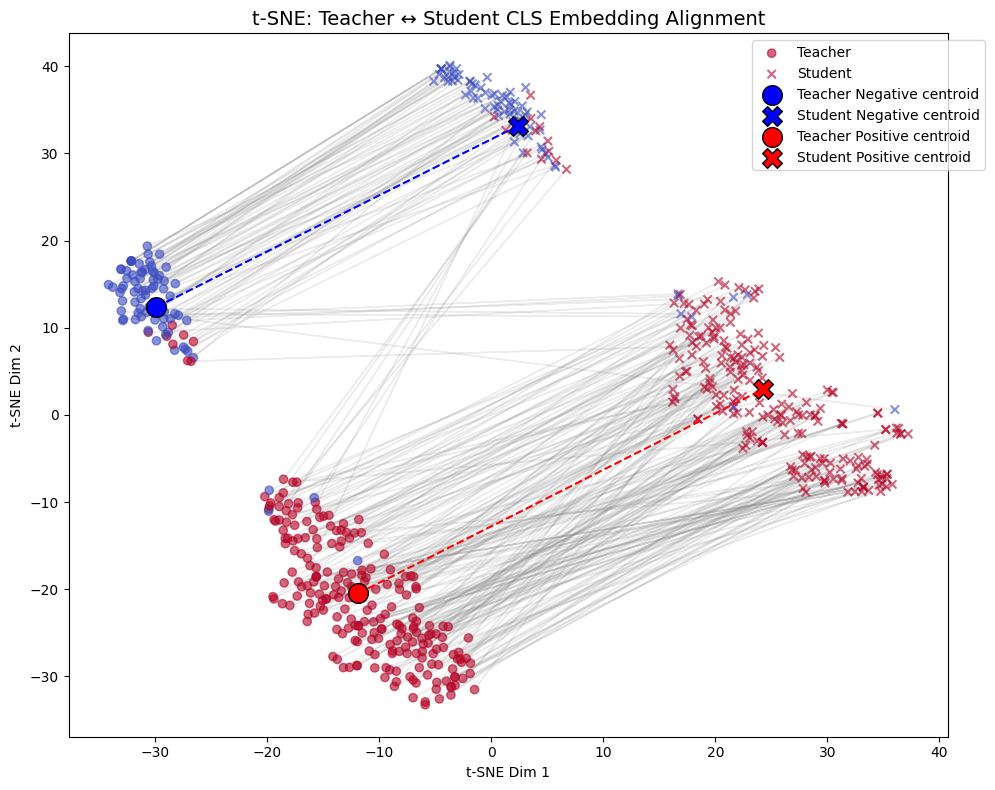

In [15]:
# ==============================================================
# 🧠 t-SNE Visualization: Teacher ↔ Student CLS Embedding Alignment
# ==============================================================

import torch
import numpy as np
import random
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

teacher.eval()
student.eval()

# ----------------------------
# 🔹 Sample subset from validation data
# ----------------------------
num_samples = 300  # reduce for faster runtime if needed
subset_df = val_df.sample(n=min(num_samples, len(val_df)), random_state=42).reset_index(drop=True)
texts_bn = subset_df["text"].tolist()
labels = subset_df["label"].to_numpy()
print(f"Visualizing {len(texts_bn)} validation samples")

# ----------------------------
# 🔹 Helper: extract CLS embeddings safely
# ----------------------------
def extract_cls_embeddings(model, tokenizer, texts, use_translit=False,
                           batch_size=16, max_len=128):
    """
    Extracts CLS embeddings for any HuggingFace or custom StudentClassifier model.
    """
    all_cls = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding batches"):
        batch_texts = texts[i : i + batch_size]
        if use_translit:
            batch_texts = [transliterate_bn_text(t) for t in batch_texts]

        enc = tokenizer(
            batch_texts,
            truncation=True,
            padding=True,
            max_length=max_len,
            return_tensors="pt"
        ).to(DEVICE)

        with torch.no_grad():
            # ⚙️ Safe forward call (no return_dict=True)
            out = model(**enc, output_hidden_states=True)
            # Works for both dict-based outputs and transformers.ModelOutput
            hidden = out["hidden_states"] if isinstance(out, dict) else out.hidden_states
            cls_vecs = hidden[-1][:, 0, :].detach().cpu().numpy()
        all_cls.append(cls_vecs)

    return np.concatenate(all_cls, axis=0)

# ----------------------------
# 🔹 Extract embeddings
# ----------------------------
print("Extracting teacher CLS embeddings ...")
teacher_embs = extract_cls_embeddings(
    teacher, teacher_tok, texts_bn,
    use_translit=False, batch_size=BATCH_SIZE, max_len=MAX_LENGTH_TEACHER
)

print("Extracting student CLS embeddings ...")
student_embs = extract_cls_embeddings(
    student, student_tok, texts_bn,
    use_translit=True, batch_size=BATCH_SIZE, max_len=MAX_LENGTH_STUDENT
)

# ----------------------------
# 🔹 Run t-SNE (new sklearn uses max_iter)
# ----------------------------
print("Running t-SNE (≈1–2 min) ...")
all_embs = np.concatenate([teacher_embs, student_embs], axis=0)
tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42,
    max_iter=1500,     # ✅ replaced n_iter with max_iter
    init="pca",
    learning_rate="auto"
)
all_2d = tsne.fit_transform(all_embs)

n = len(texts_bn)
teacher_2d, student_2d = all_2d[:n], all_2d[n:]

# ----------------------------
# 🔹 Compute centroids
# ----------------------------
centroids = {}
for label in np.unique(labels):
    centroids[(label, "teacher")] = teacher_2d[labels == label].mean(axis=0)
    centroids[(label, "student")] = student_2d[labels == label].mean(axis=0)

# ----------------------------
# 🔹 Plot alignment
# ----------------------------
plt.figure(figsize=(10, 8))

# Arrows teacher→student
for i in range(n):
    plt.arrow(
        teacher_2d[i, 0], teacher_2d[i, 1],
        student_2d[i, 0] - teacher_2d[i, 0],
        student_2d[i, 1] - teacher_2d[i, 1],
        color="gray", alpha=0.15, head_width=0.0, length_includes_head=True
    )

# Teacher points
plt.scatter(
    teacher_2d[:, 0], teacher_2d[:, 1],
    c=labels, cmap="coolwarm", marker="o", alpha=0.6, label="Teacher"
)

# Student points
plt.scatter(
    student_2d[:, 0], student_2d[:, 1],
    c=labels, cmap="coolwarm", marker="x", alpha=0.6, label="Student"
)

# Centroids
for label, color, name in [(0, "blue", "Negative"), (1, "red", "Positive")]:
    t_c = centroids[(label, "teacher")]
    s_c = centroids[(label, "student")]
    plt.scatter(*t_c, color=color, edgecolor="k", s=200, marker="o", label=f"Teacher {name} centroid")
    plt.scatter(*s_c, color=color, edgecolor="k", s=200, marker="X", label=f"Student {name} centroid")
    plt.plot([t_c[0], s_c[0]], [t_c[1], s_c[1]], color=color, linestyle="--", linewidth=1.5)

plt.title("t-SNE: Teacher ↔ Student CLS Embedding Alignment", fontsize=14)
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.tight_layout()
plt.show()


Evaluating logit alignment:   0%|          | 0/74 [00:00<?, ?it/s]

🔹 Logit Alignment Metrics:
Cosine Similarity (↑): 0.9516
KL Divergence (↓):     0.2602
MSE (↓):               0.045738


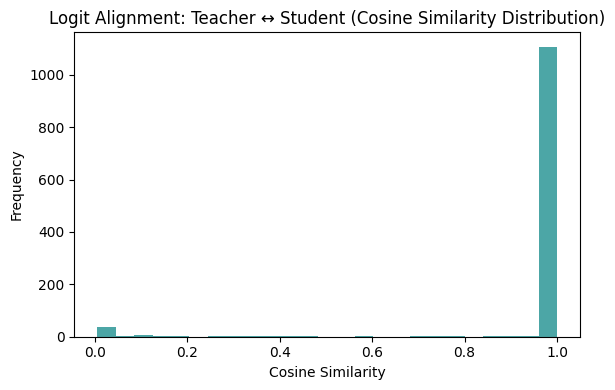

In [16]:
# ==============================================================
# ⚖️ Logit Alignment Evaluation: Teacher ↔ Student
# ==============================================================

import torch
import numpy as np
from scipy.special import softmax
from scipy.spatial.distance import cosine
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

@torch.no_grad()
def compute_logit_alignment(teacher, student, df, batch_size=16):
    teacher.eval()
    student.eval()

    # Prepare loaders
    t_dataset = SimpleDataset(df, teacher_tok, MAX_LENGTH_TEACHER, use_translit=False)
    s_dataset = SimpleDataset(df, student_tok, MAX_LENGTH_STUDENT, use_translit=True)

    t_loader = DataLoader(
        t_dataset, batch_size=batch_size, shuffle=False,
        collate_fn=lambda b: pad_collate(b, teacher_tok.pad_token_id)
    )
    s_loader = DataLoader(
        s_dataset, batch_size=batch_size, shuffle=False,
        collate_fn=lambda b: pad_collate(b, student_tok.pad_token_id)
    )

    # Ensure same length
    assert len(t_loader) == len(s_loader), "Teacher and student loaders must align!"

    cosine_sims, kl_divs, mse_vals = [], [], []

    for (bt, bs) in tqdm(zip(t_loader, s_loader), total=len(t_loader), desc="Evaluating logit alignment"):
        bt = {k: v.to(DEVICE) for k, v in bt.items()}
        bs = {k: v.to(DEVICE) for k, v in bs.items()}

        # ---------- Forward passes ----------
        out_t = teacher(**{k: v for k, v in bt.items() if k != "labels"})
        out_s = student(input_ids=bs["input_ids"], attention_mask=bs["attention_mask"])

        # Logits → softmax
        t_logits = out_t.logits.detach().cpu().numpy()
        s_logits = out_s["logits"].detach().cpu().numpy()

        t_probs = softmax(t_logits, axis=-1)
        s_probs = softmax(s_logits, axis=-1)

        # ---------- Alignment metrics ----------
        for t_p, s_p in zip(t_probs, s_probs):
            cosine_sims.append(1 - cosine(t_p, s_p))  # cosine similarity
            kl_divs.append(np.sum(t_p * np.log((t_p + 1e-9) / (s_p + 1e-9))))  # KL(T || S)
            mse_vals.append(np.mean((t_p - s_p) ** 2))  # MSE between probs

    return {
        "cosine_mean": float(np.mean(cosine_sims)),
        "kl_mean": float(np.mean(kl_divs)),
        "mse_mean": float(np.mean(mse_vals)),
        "cosine_all": cosine_sims,
        "kl_all": kl_divs,
        "mse_all": mse_vals,
    }

# ----------------------------
# 🔹 Run evaluation
# ----------------------------
logit_alignment = compute_logit_alignment(teacher, student, val_df, batch_size=BATCH_SIZE)

print("🔹 Logit Alignment Metrics:")
print(f"Cosine Similarity (↑): {logit_alignment['cosine_mean']:.4f}")
print(f"KL Divergence (↓):     {logit_alignment['kl_mean']:.4f}")
print(f"MSE (↓):               {logit_alignment['mse_mean']:.6f}")

# ----------------------------
# 🔹 Optional Visualization
# ----------------------------
plt.figure(figsize=(6,4))
plt.hist(logit_alignment["cosine_all"], bins=25, color="teal", alpha=0.7)
plt.title("Logit Alignment: Teacher ↔ Student (Cosine Similarity Distribution)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


Evaluating confidence alignment:   0%|          | 0/74 [00:00<?, ?it/s]

🔹 Pearson correlation between teacher and student confidence: 0.1121


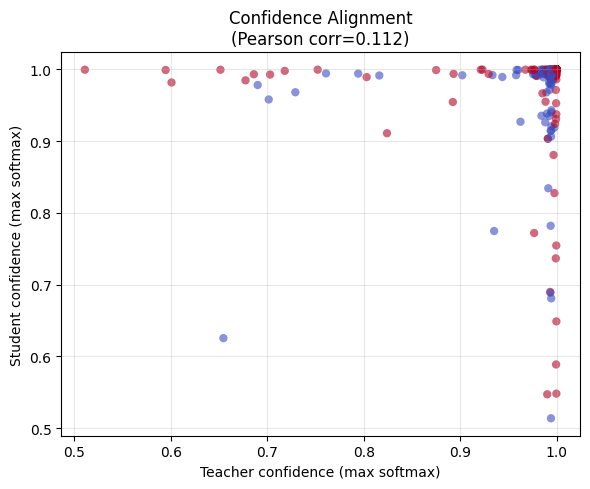

In [17]:
# ==============================================================
# 🎯 Confidence Alignment Visualization (Teacher vs Student)
# ==============================================================

import torch
import numpy as np
from scipy.special import softmax
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

@torch.no_grad()
def compute_confidence_alignment(teacher, student, df, batch_size=16):
    teacher.eval()
    student.eval()

    t_dataset = SimpleDataset(df, teacher_tok, MAX_LENGTH_TEACHER, use_translit=False)
    s_dataset = SimpleDataset(df, student_tok, MAX_LENGTH_STUDENT, use_translit=True)

    t_loader = DataLoader(
        t_dataset, batch_size=batch_size, shuffle=False,
        collate_fn=lambda b: pad_collate(b, teacher_tok.pad_token_id)
    )
    s_loader = DataLoader(
        s_dataset, batch_size=batch_size, shuffle=False,
        collate_fn=lambda b: pad_collate(b, student_tok.pad_token_id)
    )

    teacher_conf, student_conf, labels = [], [], []

    for (bt, bs) in tqdm(zip(t_loader, s_loader), total=len(t_loader), desc="Evaluating confidence alignment"):
        bt = {k: v.to(DEVICE) for k, v in bt.items()}
        bs = {k: v.to(DEVICE) for k, v in bs.items()}

        out_t = teacher(**{k: v for k, v in bt.items() if k != "labels"})
        out_s = student(input_ids=bs["input_ids"], attention_mask=bs["attention_mask"])

        t_probs = softmax(out_t.logits.detach().cpu().numpy(), axis=-1)
        s_probs = softmax(out_s["logits"].detach().cpu().numpy(), axis=-1)

        teacher_conf += t_probs.max(axis=-1).tolist()
        student_conf += s_probs.max(axis=-1).tolist()
        labels += bt["labels"].cpu().tolist()

    return np.array(teacher_conf), np.array(student_conf), np.array(labels)

# ----------------------------
# 🔹 Run evaluation
# ----------------------------
teacher_conf, student_conf, conf_labels = compute_confidence_alignment(teacher, student, val_df, batch_size=BATCH_SIZE)

# ----------------------------
# 🔹 Compute correlation
# ----------------------------
corr = np.corrcoef(teacher_conf, student_conf)[0,1]
print(f"🔹 Pearson correlation between teacher and student confidence: {corr:.4f}")

# ----------------------------
# 🔹 Scatter plot visualization
# ----------------------------
plt.figure(figsize=(6,5))
plt.scatter(teacher_conf, student_conf, c=conf_labels, cmap="coolwarm", alpha=0.6, edgecolors="none")
plt.xlabel("Teacher confidence (max softmax)")
plt.ylabel("Student confidence (max softmax)")
plt.title(f"Confidence Alignment\n(Pearson corr={corr:.3f})")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [18]:
# ==============================================================
# 🧩 Alignment Evaluation: Teacher ↔ Student
# ==============================================================

import torch
import numpy as np
from scipy.special import softmax
from scipy.spatial.distance import cosine
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

@torch.no_grad()
def evaluate_alignment(teacher, student, df, batch_size=16):
    teacher.eval()
    student.eval()

    # Build parallel datasets (Bangla for teacher, transliterated for student)
    t_dataset = SimpleDataset(df, teacher_tok, MAX_LENGTH_TEACHER, use_translit=False)
    s_dataset = SimpleDataset(df, student_tok, MAX_LENGTH_STUDENT, use_translit=True)

    t_loader = DataLoader(
        t_dataset, batch_size=batch_size, shuffle=False,
        collate_fn=lambda b: pad_collate(b, teacher_tok.pad_token_id)
    )
    s_loader = DataLoader(
        s_dataset, batch_size=batch_size, shuffle=False,
        collate_fn=lambda b: pad_collate(b, student_tok.pad_token_id)
    )

    logits_cos, prob_corr, pred_align = [], [], []
    teacher_preds, student_preds = [], []

    for (bt, bs) in tqdm(zip(t_loader, s_loader), total=len(t_loader), desc="Evaluating alignment"):
        bt = {k: v.to(DEVICE) for k, v in bt.items()}
        bs = {k: v.to(DEVICE) for k, v in bs.items()}

        # Forward pass
        out_t = teacher(**{k: v for k, v in bt.items() if k != "labels"})
        out_s = student(input_ids=bs["input_ids"], attention_mask=bs["attention_mask"])

        t_logits = out_t.logits.detach().cpu().numpy()
        s_logits = out_s["logits"].detach().cpu().numpy()
        t_probs = softmax(t_logits, axis=-1)
        s_probs = softmax(s_logits, axis=-1)

        # Batch metrics
        for t_l, s_l, t_p, s_p in zip(t_logits, s_logits, t_probs, s_probs):
            logits_cos.append(1 - cosine(t_l, s_l))
            prob_corr.append(np.corrcoef(t_p, s_p)[0, 1])
            teacher_preds.append(np.argmax(t_p))
            student_preds.append(np.argmax(s_p))

    teacher_preds = np.array(teacher_preds)
    student_preds = np.array(student_preds)
    pred_agreement = (teacher_preds == student_preds).mean()

    # Aggregate results
    return {
        "logit_cosine": float(np.nanmean(logits_cos)),
        "prob_corr": float(np.nanmean(prob_corr)),
        "pred_alignment": float(pred_agreement)
    }

# ----------------------------
# 🔹 Run evaluation on validation set
# ----------------------------
alignment = evaluate_alignment(teacher, student, val_df, batch_size=BATCH_SIZE)

print(f"""
🧩 Alignment Results:
  🔹 Logit Cosine Similarity : {alignment['logit_cosine']:.4f}
  🔹 Probability Correlation : {alignment['prob_corr']:.4f}
  🔹 Prediction Agreement    : {alignment['pred_alignment']:.4f}
""")


Evaluating alignment:   0%|          | 0/74 [00:00<?, ?it/s]


🧩 Alignment Results:
  🔹 Logit Cosine Similarity : 0.8884
  🔹 Probability Correlation : 0.8899
  🔹 Prediction Agreement    : 0.9450

